#### BERT Sequence Classifier Reference Blogpost 
https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [1]:
!pip install -U torch==1.9.0

In [2]:
!pip install transformers

In [3]:
!pip install pickle5

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, AdamW, BertConfig, get_linear_schedule_with_warmup
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pickle5 as pkl
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import Adam
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

In [5]:
train_dataset_path = "tos_clauses_train.csv"
test_dataset_path = "tos_clauses_dev.csv"
train_df = pd.read_csv(train_dataset_path, header=0)
test_df = pd.read_csv(test_dataset_path, header=0)

In [6]:
def read_embeddings():
    train_avg_embeddings_file_path = "train_avg_embeddings.pkl"
    with open(train_avg_embeddings_file_path, mode="rb") as train_file:
        train_data = pkl.load(train_file) 
    test_avg_embeddings_file_path = "test_avg_embeddings.pkl"
    with open(test_avg_embeddings_file_path, mode="rb") as test_file:
        test_data = pkl.load(test_file) 
    return train_data, test_data

train_data, test_data = read_embeddings()


In [7]:
df_train = pd.DataFrame(train_data)
df_train["embeddings"] = df_train.values.tolist()
df_train = df_train[["embeddings"]]
df_train["label"] = train_df["label"]

In [8]:
df_test = pd.DataFrame(test_data)
df_test["embeddings"] = df_test.values.tolist()
df_test = df_test[["embeddings"]]
df_test["label"] = test_df["label"]
df_test.head(1)

,embeddings,label
0,"[0.13353028893470764, 0.7151040434837341, 0.25...",0


In [9]:
class TensorDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = np.array(self.data.loc[index, 'embeddings'])
        label = int(self.data.loc[index, 'label'])
        return torch.from_numpy(features).float(), label
    
    def __getindexlist__(self):
        return list(self.data.index.values)

work_train = df_train.copy()
work_test = df_test.copy()
X_train_tensor = TensorDataset(work_train)
X_test_tensor = TensorDataset(work_test)

num_of_workers = 0
batch_size = 100
valid_size = 0.2

num_train = len(X_train_tensor)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print(len(train_idx))
print(len(valid_idx))
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_of_workers, drop_last=True)
valid_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_of_workers, drop_last=True)
test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=batch_size, 
    num_workers=num_of_workers, drop_last=True)

6025
1506


In [10]:
train_df_by_index = work_train.loc[train_idx]
val_df_by_index = work_train.loc[valid_idx]
train_fair = sum(train_df_by_index['label'] == 0)
train_unfair = sum(train_df_by_index['label'] == 1)
val_fair = sum(val_df_by_index['label'] == 0)
val_unfair = sum(val_df_by_index['label'] == 1)

print("train_fair:" + str(train_fair))
print("train_unfair:" + str(train_unfair))
print("val_fair:" + str(val_fair))
print("val_unfair:" + str(val_unfair))

train_fair:5362
train_unfair:663
val_fair:1343
val_unfair:163


In [11]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    
    
optimizer = AdamW(model.parameters(),lr = 5e-5, eps = 1e-8)

epochs = 4
total_steps = len(train_loader) * epochs



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [14]:
y = torch.FloatTensor(df_train.label.tolist())
class_weights=compute_class_weight('balanced',classes=np.unique(y),y=y.numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)
class_weights

tensor([0.5616, 4.5587])

In [15]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs, train_idx, val_idx):
    epoch_nums_list = []
    train_loss_list = []
    val_loss_list = []
    model.train()
    criterion = nn.CrossEntropyLoss(weight = class_weights)
    for epoch_num in range(epochs):
        print("Epoch: " + str(epoch_num))
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            model.zero_grad()
            train_input = torch.reshape(train_input, (batch_size, 1, 768))
            output = model(inputs_embeds = train_input, labels = train_label.long())
            logits = output[1]
            loss = criterion(logits, train_label.long())
            total_loss_train += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            
            logits = logits.detach().numpy()
            acc = flat_accuracy(logits, train_label.numpy())
            total_acc_train += acc
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_input = torch.reshape(val_input, (batch_size, 1, 768))
                output = model(inputs_embeds = val_input, labels = train_label.long())
                logits = output[1]
                loss = criterion(logits, train_label.long())
                total_loss_val += loss.item()
                    
                
                logits = logits.detach().numpy()
                acc = flat_accuracy(logits, val_label.numpy())
                total_acc_val += acc
            
        print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_idx): .3f} \
                | Train Accuracy: {total_acc_train / len(train_dataloader): .3f} \
                | Val Loss: {total_loss_val / len(val_idx): .3f} \
                | Val Accuracy: {total_acc_val / len(val_dataloader): .3f}')
        epoch_nums_list.append(epoch_num)
        train_loss_list.append(1- (total_acc_train / len(train_dataloader)))
        val_loss_list.append(1- (total_acc_val / len(val_dataloader)))
        if epoch_num in [1, 5, 10, 20, 30, 40, 50]:
            torch.save(model.state_dict(), "bert_sc_avg_models/" + "bscmod_" + str(epoch_num) + "_file.pt")
    return epoch_nums_list, train_loss_list, val_loss_list
EPOCHS = 50
LR = 1e-6
              
epoch_nums_list, train_loss_list, val_loss_list = train(model, train_loader, valid_loader, LR, EPOCHS, train_idx, valid_idx)

  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epoch: 0


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.007                 | Train Accuracy:  0.543                 | Val Loss:  0.007                 | Val Accuracy:  0.311
Epoch: 1


100%|███████████████████████████████████████████| 60/60 [00:19<00:00,  3.07it/s]


Epochs: 2 | Train Loss:  0.007                 | Train Accuracy:  0.553                 | Val Loss:  0.007                 | Val Accuracy:  0.390


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epoch: 2


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 3 | Train Loss:  0.007                 | Train Accuracy:  0.591                 | Val Loss:  0.007                 | Val Accuracy:  0.861
Epoch: 3


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 4 | Train Loss:  0.007                 | Train Accuracy:  0.578                 | Val Loss:  0.007                 | Val Accuracy:  0.297
Epoch: 4


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 5 | Train Loss:  0.007                 | Train Accuracy:  0.573                 | Val Loss:  0.008                 | Val Accuracy:  0.464
Epoch: 5


100%|███████████████████████████████████████████| 60/60 [00:19<00:00,  3.05it/s]


Epochs: 6 | Train Loss:  0.007                 | Train Accuracy:  0.669                 | Val Loss:  0.007                 | Val Accuracy:  0.154


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epoch: 6


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 7 | Train Loss:  0.007                 | Train Accuracy:  0.598                 | Val Loss:  0.008                 | Val Accuracy:  0.813
Epoch: 7


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 8 | Train Loss:  0.007                 | Train Accuracy:  0.672                 | Val Loss:  0.007                 | Val Accuracy:  0.709
Epoch: 8


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 9 | Train Loss:  0.006                 | Train Accuracy:  0.623                 | Val Loss:  0.008                 | Val Accuracy:  0.629
Epoch: 9


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 10 | Train Loss:  0.006                 | Train Accuracy:  0.681                 | Val Loss:  0.007                 | Val Accuracy:  0.863
Epoch: 10


100%|███████████████████████████████████████████| 60/60 [00:19<00:00,  3.08it/s]


Epochs: 11 | Train Loss:  0.006                 | Train Accuracy:  0.677                 | Val Loss:  0.007                 | Val Accuracy:  0.793


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epoch: 11


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 12 | Train Loss:  0.006                 | Train Accuracy:  0.654                 | Val Loss:  0.007                 | Val Accuracy:  0.477
Epoch: 12


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 13 | Train Loss:  0.006                 | Train Accuracy:  0.672                 | Val Loss:  0.008                 | Val Accuracy:  0.593
Epoch: 13


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 14 | Train Loss:  0.006                 | Train Accuracy:  0.679                 | Val Loss:  0.007                 | Val Accuracy:  0.705
Epoch: 14


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 15 | Train Loss:  0.006                 | Train Accuracy:  0.658                 | Val Loss:  0.007                 | Val Accuracy:  0.749
Epoch: 15


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 16 | Train Loss:  0.006                 | Train Accuracy:  0.663                 | Val Loss:  0.008                 | Val Accuracy:  0.876
Epoch: 16


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 17 | Train Loss:  0.006                 | Train Accuracy:  0.711                 | Val Loss:  0.009                 | Val Accuracy:  0.718
Epoch: 17


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 18 | Train Loss:  0.007                 | Train Accuracy:  0.553                 | Val Loss:  0.008                 | Val Accuracy:  0.741
Epoch: 18


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 19 | Train Loss:  0.006                 | Train Accuracy:  0.737                 | Val Loss:  0.007                 | Val Accuracy:  0.827
Epoch: 19


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 20 | Train Loss:  0.007                 | Train Accuracy:  0.688                 | Val Loss:  0.007                 | Val Accuracy:  0.527
Epoch: 20


100%|███████████████████████████████████████████| 60/60 [00:19<00:00,  3.09it/s]


Epochs: 21 | Train Loss:  0.007                 | Train Accuracy:  0.657                 | Val Loss:  0.008                 | Val Accuracy:  0.851


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epoch: 21


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 22 | Train Loss:  0.006                 | Train Accuracy:  0.715                 | Val Loss:  0.007                 | Val Accuracy:  0.790
Epoch: 22


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 23 | Train Loss:  0.006                 | Train Accuracy:  0.704                 | Val Loss:  0.008                 | Val Accuracy:  0.721
Epoch: 23


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 24 | Train Loss:  0.007                 | Train Accuracy:  0.599                 | Val Loss:  0.008                 | Val Accuracy:  0.797
Epoch: 24


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 25 | Train Loss:  0.006                 | Train Accuracy:  0.709                 | Val Loss:  0.008                 | Val Accuracy:  0.829
Epoch: 25


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 26 | Train Loss:  0.006                 | Train Accuracy:  0.636                 | Val Loss:  0.007                 | Val Accuracy:  0.824
Epoch: 26


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 27 | Train Loss:  0.006                 | Train Accuracy:  0.731                 | Val Loss:  0.008                 | Val Accuracy:  0.700
Epoch: 27


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 28 | Train Loss:  0.006                 | Train Accuracy:  0.669                 | Val Loss:  0.007                 | Val Accuracy:  0.312
Epoch: 28


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 29 | Train Loss:  0.007                 | Train Accuracy:  0.635                 | Val Loss:  0.008                 | Val Accuracy:  0.195
Epoch: 29


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 30 | Train Loss:  0.007                 | Train Accuracy:  0.733                 | Val Loss:  0.007                 | Val Accuracy:  0.691
Epoch: 30


100%|███████████████████████████████████████████| 60/60 [00:19<00:00,  3.06it/s]


Epochs: 31 | Train Loss:  0.006                 | Train Accuracy:  0.738                 | Val Loss:  0.007                 | Val Accuracy:  0.645


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epoch: 31


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 32 | Train Loss:  0.007                 | Train Accuracy:  0.654                 | Val Loss:  0.007                 | Val Accuracy:  0.701
Epoch: 32


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 33 | Train Loss:  0.006                 | Train Accuracy:  0.699                 | Val Loss:  0.008                 | Val Accuracy:  0.642
Epoch: 33


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 34 | Train Loss:  0.006                 | Train Accuracy:  0.699                 | Val Loss:  0.009                 | Val Accuracy:  0.683
Epoch: 34


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 35 | Train Loss:  0.006                 | Train Accuracy:  0.694                 | Val Loss:  0.008                 | Val Accuracy:  0.615
Epoch: 35


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 36 | Train Loss:  0.006                 | Train Accuracy:  0.720                 | Val Loss:  0.009                 | Val Accuracy:  0.837
Epoch: 36


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 37 | Train Loss:  0.006                 | Train Accuracy:  0.698                 | Val Loss:  0.008                 | Val Accuracy:  0.477
Epoch: 37


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 38 | Train Loss:  0.006                 | Train Accuracy:  0.694                 | Val Loss:  0.009                 | Val Accuracy:  0.716
Epoch: 38


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 39 | Train Loss:  0.006                 | Train Accuracy:  0.750                 | Val Loss:  0.008                 | Val Accuracy:  0.793
Epoch: 39


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 40 | Train Loss:  0.006                 | Train Accuracy:  0.769                 | Val Loss:  0.008                 | Val Accuracy:  0.687
Epoch: 40


100%|███████████████████████████████████████████| 60/60 [00:19<00:00,  3.06it/s]


Epochs: 41 | Train Loss:  0.007                 | Train Accuracy:  0.701                 | Val Loss:  0.008                 | Val Accuracy:  0.830


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epoch: 41


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 42 | Train Loss:  0.007                 | Train Accuracy:  0.677                 | Val Loss:  0.007                 | Val Accuracy:  0.149
Epoch: 42


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 43 | Train Loss:  0.007                 | Train Accuracy:  0.585                 | Val Loss:  0.007                 | Val Accuracy:  0.113
Epoch: 43


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 44 | Train Loss:  0.007                 | Train Accuracy:  0.444                 | Val Loss:  0.007                 | Val Accuracy:  0.633
Epoch: 44


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 45 | Train Loss:  0.007                 | Train Accuracy:  0.521                 | Val Loss:  0.007                 | Val Accuracy:  0.854
Epoch: 45


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 46 | Train Loss:  0.007                 | Train Accuracy:  0.654                 | Val Loss:  0.007                 | Val Accuracy:  0.835
Epoch: 46


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 47 | Train Loss:  0.007                 | Train Accuracy:  0.567                 | Val Loss:  0.006                 | Val Accuracy:  0.831
Epoch: 47


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 48 | Train Loss:  0.007                 | Train Accuracy:  0.573                 | Val Loss:  0.007                 | Val Accuracy:  0.881
Epoch: 48


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Epochs: 49 | Train Loss:  0.007                 | Train Accuracy:  0.551                 | Val Loss:  0.007                 | Val Accuracy:  0.395
Epoch: 49


100%|███████████████████████████████████████████| 60/60 [00:19<00:00,  3.01it/s]


Epochs: 50 | Train Loss:  0.007                 | Train Accuracy:  0.460                 | Val Loss:  0.007                 | Val Accuracy:  0.177


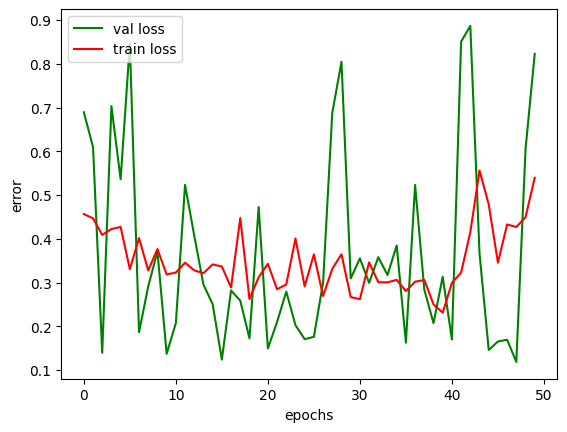

In [16]:
plt.plot(epoch_nums_list, val_loss_list, color = 'green', label = 'val loss')
plt.plot(epoch_nums_list, train_loss_list, color = 'red', label = 'train loss')
plt.legend(loc = 'upper left')
plt.ylabel('error')
plt.xlabel('epochs')
plt.show()

In [17]:
def evaluate(model, test_dataloader, test_data):
    prediction_list = []
    actual_list = []
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            test_input = torch.reshape(test_input, (len(test_data), 1, 768))
            output = model(inputs_embeds = test_input)
            logits = output[0]
            logits = logits.detach().numpy()
            print(logits)
            acc = flat_accuracy(logits, test_label.numpy())
            total_acc_test += acc
            
            prediction_list.append(logits.argmax(axis=1))
            actual_list.append(test_label)
    
    print(f'Test Accuracy: {total_acc_test / len(test_dataloader): .3f}')
    
    return prediction_list[0].tolist(), actual_list[0].tolist()

test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=len(df_test), num_workers=num_of_workers, drop_last=True)
prediction_list, actual_list = evaluate(model, test_loader, df_test)
report = classification_report(actual_list, prediction_list, output_dict=True)
report

[[-1.3910445   0.9654546 ]
 [-0.31363028 -0.45822918]
 [-0.6206039  -0.45509967]
 ...
 [-0.55615383 -0.11399452]
 [-0.6475568  -0.45252803]
 [-0.5860856  -0.2593333 ]]
Test Accuracy:  0.172


{'0': {'precision': 0.86875,
  'recall': 0.0828861061419201,
  'f1-score': 0.15133369624387588,
  'support': 1677},
 '1': {'precision': 0.1073708647707487,
  'recall': 0.8980582524271845,
  'f1-score': 0.1918092275790565,
  'support': 206},
 'accuracy': 0.17206585236325014,
 'macro avg': {'precision': 0.48806043238537433,
  'recall': 0.49047217928455233,
  'f1-score': 0.1715714619114662,
  'support': 1883},
 'weighted avg': {'precision': 0.7854552034746544,
  'recall': 0.17206585236325014,
  'f1-score': 0.1557617150728972,
  'support': 1883}}

In [18]:
from tabulate import tabulate
import os 

def evaluate(test_dataloader, test_data):
    #bert_sc_avg_models
    path = "bert_sc_avg_models/"
    files = os.listdir("./bert_sc_avg_models/")
    for file in files:
        print("Model Epoch: " + file)
        curr_model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels = 2,
            output_attentions = False,
            output_hidden_states = False,)

        curr_model.load_state_dict(torch.load(path + file))
        prediction_list = []
        actual_list = []
        total_acc_test = 0
        with torch.no_grad():
            for test_input, test_label in test_dataloader:
                test_input = torch.reshape(test_input, (len(test_data), 1, 768))
                output = curr_model(inputs_embeds = test_input)
                logits = output[0]
                logits = logits.detach().numpy()
                print(logits)
                acc = flat_accuracy(logits, test_label.numpy())
                total_acc_test += acc
            
                prediction_list.append(logits.argmax(axis=1))
                actual_list.append(test_label)
    
        print(f'Test Accuracy: {total_acc_test / len(test_dataloader): .3f}')
        report = classification_report(actual_list[0].tolist(), prediction_list[0].tolist())
        print(report)

test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=len(df_test), num_workers=num_of_workers, drop_last=True)
evaluate(test_loader, df_test)

Model Epoch: bscmod_30_file.pt


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[[-0.24246478 -0.9180114 ]
 [-0.24244367 -0.9196203 ]
 [-0.6188512  -0.2601377 ]
 ...
 [-0.2588895  -0.8380239 ]
 [-0.38352785  1.1968216 ]
 [-0.24240191 -0.91614836]]
Test Accuracy:  0.672
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1677
           1       0.17      0.53      0.26       206

    accuracy                           0.67      1883
   macro avg       0.55      0.61      0.53      1883
weighted avg       0.84      0.67      0.73      1883

Model Epoch: bscmod_20_file.pt


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[[-0.31239715  1.4253678 ]
 [-0.3047231   1.431568  ]
 [-0.03744207 -1.0691504 ]
 ...
 [-0.03503022 -1.0797017 ]
 [-0.7784205   0.1568086 ]
 [-0.32172972  1.4170558 ]]
Test Accuracy:  0.847
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1677
           1       0.32      0.35      0.33       206

    accuracy                           0.85      1883
   macro avg       0.62      0.63      0.62      1883
weighted avg       0.85      0.85      0.85      1883

Model Epoch: bscmod_40_file.pt


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[[-1.3983207   0.99287975]
 [-1.3778375   0.99010754]
 [-0.40957314 -0.7607508 ]
 ...
 [-0.4095312  -0.76201946]
 [-1.027358    0.2673858 ]
 [-1.4141288   0.9736421 ]]
Test Accuracy:  0.839
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1677
           1       0.32      0.42      0.36       206

    accuracy                           0.84      1883
   macro avg       0.62      0.66      0.64      1883
weighted avg       0.86      0.84      0.85      1883

Model Epoch: bscmod_1_file.pt


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[[-0.64774793 -0.41569316]
 [-0.5039948  -0.3849487 ]
 [-0.52476305 -0.34505624]
 ...
 [-0.45753857 -0.451393  ]
 [-0.55045867 -0.3009372 ]
 [-0.645686   -0.39247712]]
Test Accuracy:  0.202
              precision    recall  f1-score   support

           0       0.95      0.11      0.20      1677
           1       0.12      0.96      0.21       206

    accuracy                           0.20      1883
   macro avg       0.53      0.53      0.20      1883
weighted avg       0.86      0.20      0.20      1883

Model Epoch: bscmod_10_file.pt


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[[-1.0353335   0.88804424]
 [-1.0505445   0.7656844 ]
 [-0.17421977 -0.7052465 ]
 ...
 [ 0.12162696 -1.2131742 ]
 [-1.0476683   0.7516622 ]
 [-1.0390204   0.87815535]]
Test Accuracy:  0.777
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1677
           1       0.26      0.55      0.35       206

    accuracy                           0.78      1883
   macro avg       0.60      0.68      0.61      1883
weighted avg       0.86      0.78      0.81      1883

Model Epoch: bscmod_5_file.pt


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[[-1.087293    0.37157652]
 [-0.69399256 -0.34763703]
 [-0.67555624 -0.34113795]
 ...
 [-0.6637771  -0.3504065 ]
 [-1.0357461   0.31071046]
 [-1.0874041   0.35885856]]
Test Accuracy:  0.109
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1677
           1       0.11      1.00      0.20       206

    accuracy                           0.11      1883
   macro avg       0.05      0.50      0.10      1883
weighted avg       0.01      0.11      0.02      1883



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

##### Best F1 score is found at epoch 40

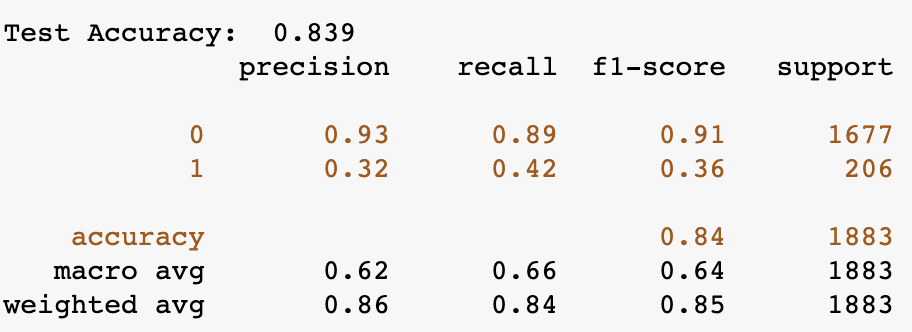